# CPSC 425 - Computer Vision

## Homework 3: Texture Synthesis

### Leo Foord-Kelcey - 83974592

**Due date: Oct 25**

### Boilerplate

In [1]:
from PIL import Image, ImageDraw

### Question 4 & 5

Implementation of `ComputeSSD()` and `CopyPatch()` are on `Holefill.py`

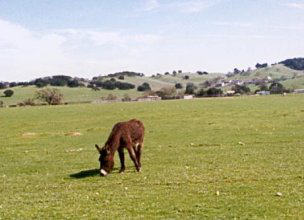

Original Donkey Image



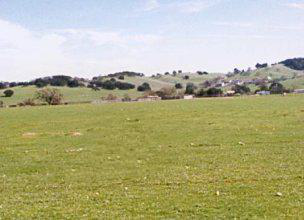

Modified Donkey Image



In [2]:
display(Image.open('donkey.jpg'))
print('Original Donkey Image\n')

display(Image.open('no_donkey.jpg'))
print('Modified Donkey Image\n')

### Question 6

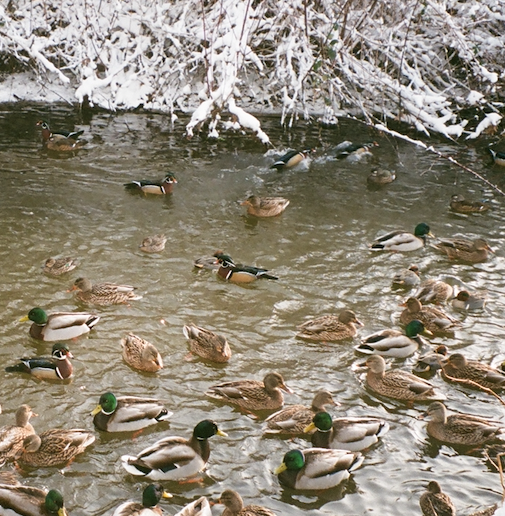

Original Mallard Image



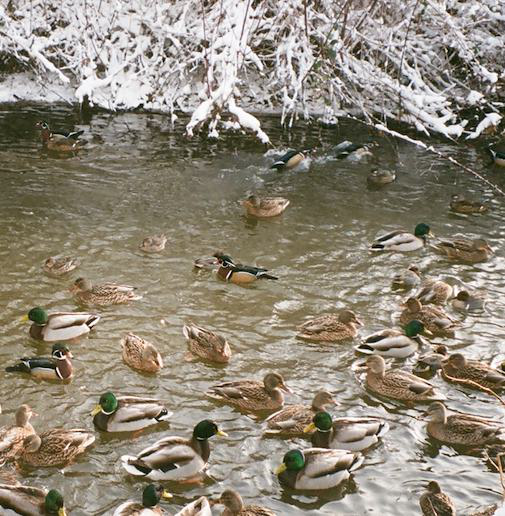

Modified Mallard Image



In [3]:
display(Image.open('mallard.jpg'))
print('Original Mallard Image\n')

display(Image.open('no_mallard.jpg'))
print('Modified Mallard Image\n')

Above is an example of the algorithm performing `well`. Notice that a mallard around the top-left of the original image has been removed in the modified image.

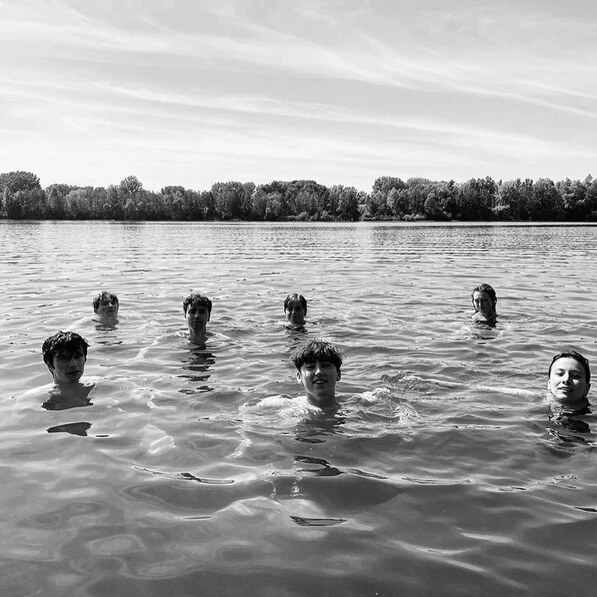

Original Swimmers Image



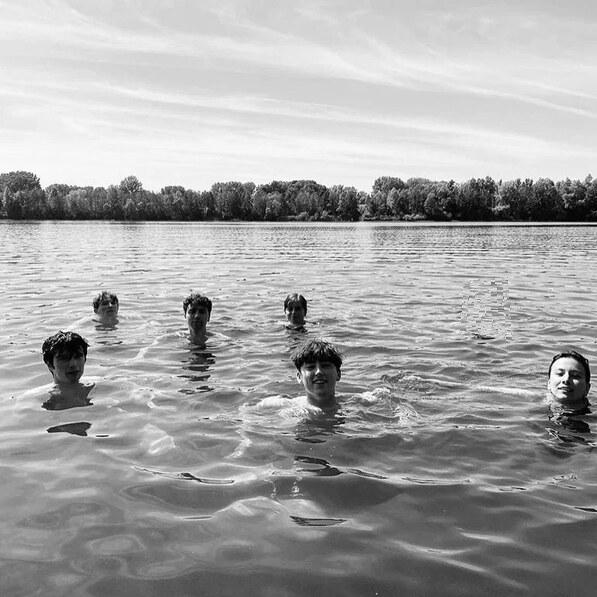

Modified Swimmers Image



In [4]:
display(Image.open('slint.jpg'))
print('Original Swimmers Image\n')

display(Image.open('bad_slint.jpg'))
print('Modified Swimmers Image\n')

Above is an example of the algorithm performing `poorly`. The reason for this poor performance is because I set `randomPatchSD to be large` and `patchL to be small`. By doing this, the algorithm uses very small synthesis patch sizes and the minimum SSD image is chosen with significant amount of random variance. The result is that the hole in the image (person swimming top right) is impainting with small patches that look very unique from one another. This makes the water look extremely unnatural with the strange artifacts - especially noticeable with a bit of zooming.<br>

### Question 7

`randomPatchSD` and `patchL` are two parameters the algorithm employs to tune the quality of the image synthesis.

Pragmatically, `randomPatchSD` defines the standard deviation (sigma) to used in a gaussian distribution. 

> abs(random.gauss(0,randomPatchSD)) 

The code (line 234 Holyfill.py) above uses this S.D. to create a gaussian distribution with a mean of 0, and then randomly selects a floating point value within that distribution. It also takes the absolute value of this result since the distribution will also provide negative values, and we can not index less than 0. 

Next, recall `ComputeSSD` returns a list of SSD values of all the sample patches from the texture image with respect to the image patch being synthesized. Then, sorting this list from smallest to largest gives us the patches that are the closest match first. 

Going back to the random float we selected in the distribution before, this value is rounded to an integer, and then used to index into this sorted list of patches. This means that, if the selected value is `0`, we chose the absolute (0th) best match for the patch, if it is `10`, we chose the 10th best match for the patch. 

Thus, simply put `randomPatchSD` defines the range of values to randomly chose an index from. If `randomPatchSD is 0`, it always returns `0`, and thus (as mentioned above) indexes the absolute (0th) best match for the patch. However, if `randomPatchSD is large`, the range of indexes that can be randomly chosen increases. 

Although superficially it would seem that always selecting the patch with smallest SSD or `randomPatchSD = 0` would be optimal, it often results in producing unrealistic `repetition`. This is because when the algorithm recursively fills in patches of the hole from its perimeter, it matches against the neighborhood of pixels around it. Without any randomness, the patches to be filled will propagate in a way that are likely to be filled the same way, since the neighborhood also looks the same. 

On the otherhand, if `randomPatchSD is large`, we increase the likelihood of matches that are not near the best. Although throwing randomness helps avoid repetition, too much of it will make the image look unnatural and full of jaggies. 

`patchL` is the distance from the center pixel of the patch to the edge. That is to the say, the size of the patch is `2 * patchL + 1`. Thus if `patchL = 1`, the sample patch has a `3x3` area, if `patch=20`, the sample patch has a `41x41` area. 

Recall the sample patch a square centered around the current pixel (that is filled) and is compared against patches of the same size in the texture image. Thus the size of the patch directly relates to how many neighboring pixels are used to compute the SSD. 

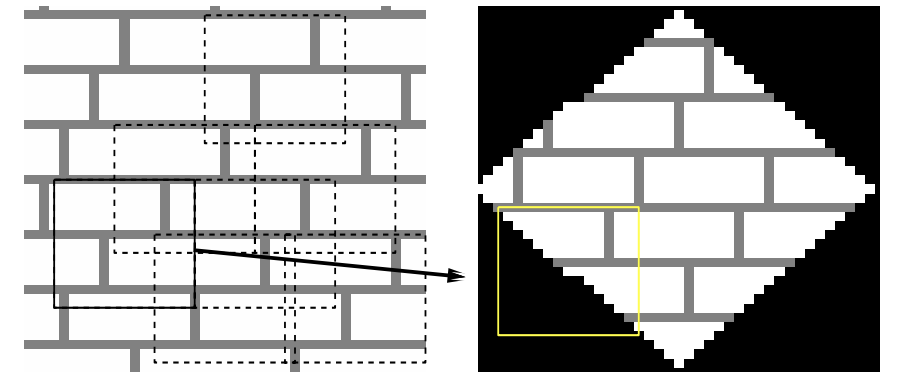

Image taken from Efros and Leung paper. Yellow square on the right is the current patch in the image, then squares on the left are patches within the texture that are being compared by SSD.



In [5]:
display(Image.open('patch.jpg'))
print('Image taken from Efros and Leung paper. Yellow square on the right is the current patch in the image, then squares on the left are patches within the texture that are being compared by SSD.\n')

Knowing this let us look at how this `patchL` affects the output of our algorithm. We notice that we get similar behavior found above with `randomPatchSD`. 

When `patchL is small`, it is not able to garner much contextual data to produce a realistic match from the texture. Thus it tends to fill in the hole randomly with noise and variance between fillings. 

On the otherhand if `patchL is large`, it will have more information to match appropriate against the sample, but it will also be limited by the size of the texture it is compared against. This decreases the number of patches in the texture we can compare against. Further, it was fill a larger subset of the hole, and thus as described with the when `randomPatchSD = 0`, we are likely to resample and create repetition. 

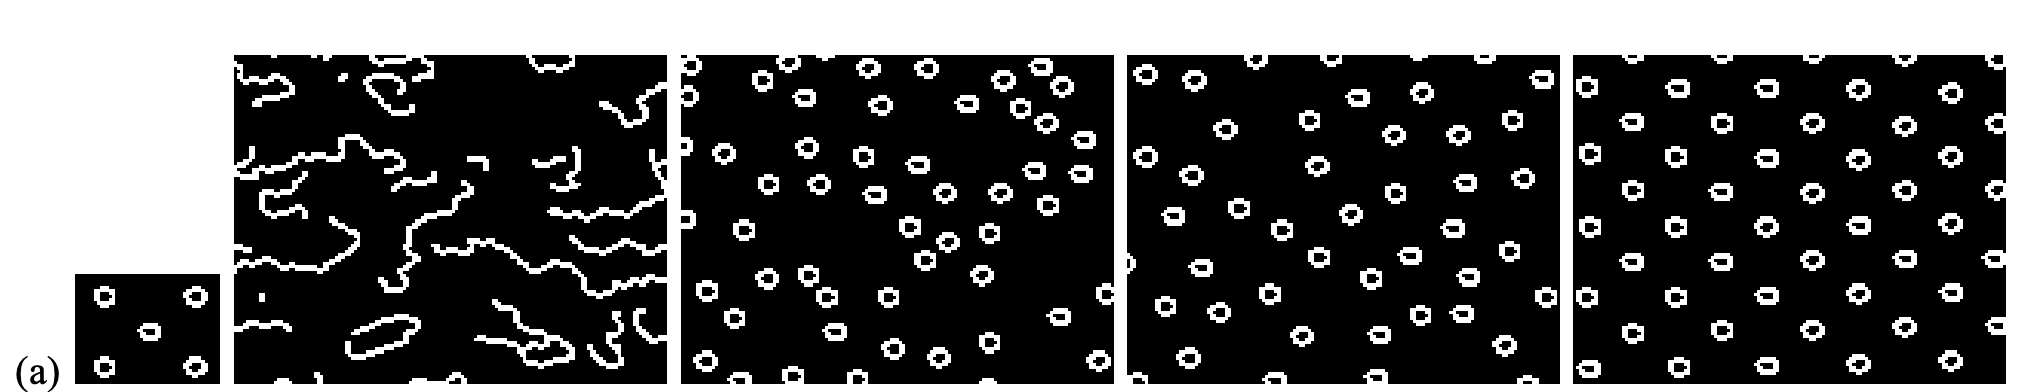

Image taken from Efros and Leung paper. See how the size of the patch affects the result of texture synthesis. Smaller patches on the left are more random, larger patches on the right are more repetitive. 



In [6]:
display(Image.open('repetition.jpg'))
print('Image taken from Efros and Leung paper. See how the size of the patch affects the result of texture synthesis. Smaller patches on the left are more random, larger patches on the right are more repetitive. \n')

For the reasons described above it is important to select an appropriate `randomPatchSD` and `patchL` respective to the image being synthesized. It is best not to always select the best match with `randomPatchSD = 0`, but we also don't want the results to be too random. It is also important to select an appropriate `patchL` with respect to the size of the texture and hole we are inpainting. 